Calculate G+C content and length of each genome

In [2]:
from __future__ import print_function
from Bio.SeqUtils import GC
import pandas as pd
import glob
import os
import os.path as op
from itertools import groupby

def read_fasta(file_handle):
    '''Fasta iterator'''
    for header, group in groupby(file_handle, lambda line: line[0] == '>'):
        if header:
            line = next(group)
            name = line[1:].strip()
        else:
            seq = ''.join(line.strip() for line in group)
            yield name, seq

In [21]:
%load_ext rpy2.ipython
%R library("dplyr"); library("ggplot2"); library("gridExtra")

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


//anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Need help getting started? Try the cookbook for R:
http://www.cookbook-r.com/Graphs/

  res = super(Function, self).__call__(*new_args, **new_kwargs)


array(['gridExtra', 'ggplot2', 'dplyr', 'tools', 'stats', 'graphics',
       'grDevices', 'utils', 'datasets', 'methods', 'base'], 
      dtype='|S9')

In [25]:
fastas = glob.glob("../fasta/*")
ginfo = {}
infotbl = "../genome_info.txt"
with open(infotbl, "w") as oh:
    print("name", "percent GC", "Genome Length", sep="\t", file=oh)
    for f in fastas:
        with open(f) as ih:
            for name, seq in read_fasta(ih):
                gc = GC(seq)
                length = len(seq)
                ginfo[name] = [gc, length]
                print(name, gc, length, sep="\t", file=oh)

Next, count the different annotation features

In [26]:
gffs = glob.glob("../gff_newnames/*")
elements=[]
features = "../virus_features.txt"

with open(features, "w") as oh:
    print("name","CDS", "tRNA", "putative CRISPR feature", sep="\t", file=oh)
    for g in gffs:
        with open(g) as ih:
            cds = 0
            trna = 0
            crispr = 0
            for i, l in enumerate(ih):
                vec = l.split("\t")
                name = vec[0]
                if vec[2] == 'CDS':
                    cds += 1
                if vec[2] == 'tRNA':
                    trna += 1
                if vec[2] == 'putative CRISPR feature':
                    crispr +=1
            print(name, cds, trna, crispr, sep="\t", file=oh)

Merge the two tables together

In [14]:
feats = pd.read_csv("../virus_features.txt", sep="\t")
ginfo = pd.read_csv("../genome_info.txt", sep="\t")

merged = pd.merge(feats, ginfo, on="name")
ndict = {i : i.split("_")[2] for i in ginfo['name']}
sl = my_dict2 = {y:x for x,y in ndict.iteritems()}

Next need to calculate coverage... download rearranged coverage files for this...

In [30]:
os.mkdir("../genomecoverage")
os.mkdir("../genomecoverage/rearranged/")

In [32]:
!scp jmb@alarmism.einstein.yu.edu:~/Desktop/ViralFate/PhageGenomeAssembly/genomecoverage/step1contig1.rearranged/* ../genomecoverage/rearranged/

Password:



In [18]:
ra = glob.glob("../genomecoverage/rearranged/*")

with open("final_coverage.txt","w") as ih:
    for r in ra:
        phage = op.basename(r).split("rearrange")[0]
        try:
            gc = pd.read_csv(r, sep="\t", header=None)
            print(sl[phage], round(gc[2].mean()), sep="\t", file=ih)
        except:
            print(phage)

1.004.O.
1.028.O.
1.031.O.


In [3]:
ra = glob.glob("../genomecoverage/rearranged/*")

In [62]:
cov_info = "final_coverage.txt"
genome_info = "../genome_info.txt"
features = "../virus_features.txt"

c = pd.read_csv(cov_info, sep="\t", names=['name','coverage'])
g = pd.read_csv(genome_info, sep="\t")
f = pd.read_csv(features, sep="\t")
t = pd.merge(c, g, on='name')

t = pd.merge(t, f, on='name')
t.to_csv("../combined_genome_info.txt", sep="\t")

In [70]:
cov_mean = t.coverage.mean()
cov_sd = t.coverage.std()
cov_min = t.coverage.min()
cov_max = t.coverage.max()

print("Coverage ranged from {cov_min} to {cov_max} with mean coverage of {cov_mean} +/- {cov_sd}".format(**locals()))

gc = t['percent GC']
gc_mean = gc.mean()
gc_sd = gc.std()
gc_min = gc.min()
gc_max = gc.max()
print("GC content ranged from {gc_min} to {gc_max} with mean gc of {gc_mean} +/- {gc_sd}".format(**locals()))

size = t['Genome Length']
size_min = size.min()
size_max = size.max()
size_mean = size.mean()
size_sd = size.std()

print("Genomes ranged in size from {size_min} to {size_max} with mean of {size_mean} +/- {size_sd}".format(**locals()))

tRNA = t[t['tRNA']>0]
tRNA_ct = len(tRNA)
print("{tRNA_ct} phages carried tRNAs".format(**locals()))

crispr = t[t['putative CRISPR feature']>0]
crispr_ct = len(crispr)
print("{crispr_ct} viruses have putative crispr feature".format(**locals()))

Coverage ranged from 27.0 to 17026.0 with mean coverage of 1141.18631179 +/- 2259.05665128
GC content ranged from 37.1027299762 to 57.6918749859 with mean gc of 44.3624087601 +/- 2.84916685201
Genomes ranged in size from 10046 to 348911 with mean of 49265.5095057 +/- 32150.95998
53 phages carried tRNAs
32 viruses have putative crispr feature


In [22]:
%%R -i t
head(t)

                                  name coverage percent.GC Genome.Length CDS
0  Vibrio_virus_1.003.O._10N.286.48.A2      953   42.84214         41891  72
1  Vibrio_virus_1.005.O._10N.286.48.F2    14049   43.96135         50301  69
2  Vibrio_virus_1.007.O._10N.261.55.F9    13064   42.84583         49244  80
3  Vibrio_virus_1.008.O._10N.286.54.E5      963   43.33113         10579  21
4  Vibrio_virus_1.009.O._10N.261.51.C9     9690   57.69187         44443  62
5 Vibrio_virus_1.011.O._10N.286.49.B11     1461   43.35949         10579  20
  tRNA putative.CRISPR.feature
0    0                       0
1    0                       0
2    4                       0
3    0                       1
4    0                       1
5    0                       1


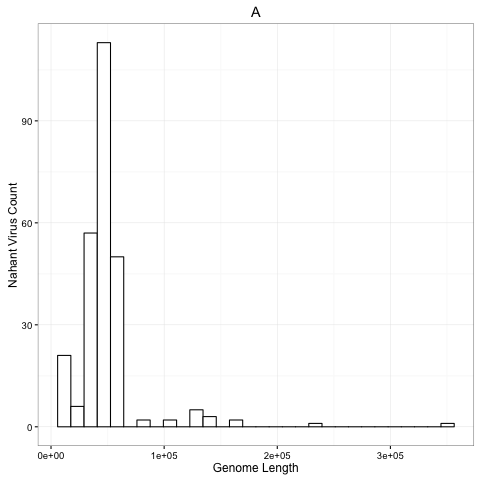

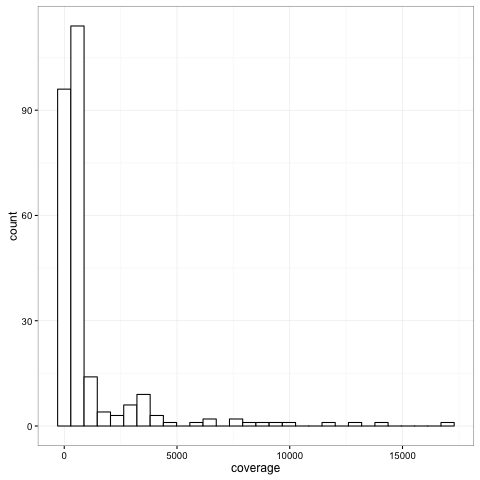

In [79]:
%%R
gc <- ggplot(t, aes(percent.GC)) + geom_histogram(fill="white", color="black") + theme_bw() 
gc <- gc + labs(x="Percent GC", y="Nahant Virus Count", title="B")

size <- t %>% ggplot(aes(Genome.Length)) + geom_histogram(fill="white", 
                                                       color="black") + theme_bw()
size <- size + labs(x="Genome Length", y="Nahant Virus Count", title="A")
plot(size)

cov <- t %>% ggplot(aes(coverage)) + geom_histogram(fill="white", 
                                                       color="black") + theme_bw()
plot(cov)

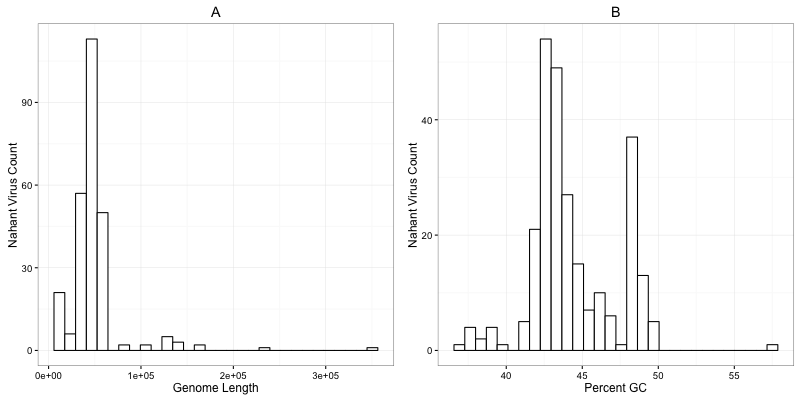

In [80]:
%%R -w 800 -h 400
panels <- grid.arrange(size, gc,
             ncol = 2, nrow = 1, widths = c(6, 6), heights = c(8))


In [81]:
%%R
png(filename = "../nvv_len_gc.png",
   width=800, height=400, units="px")
plot(panels)
dev.off()

quartz_off_screen 
                7 


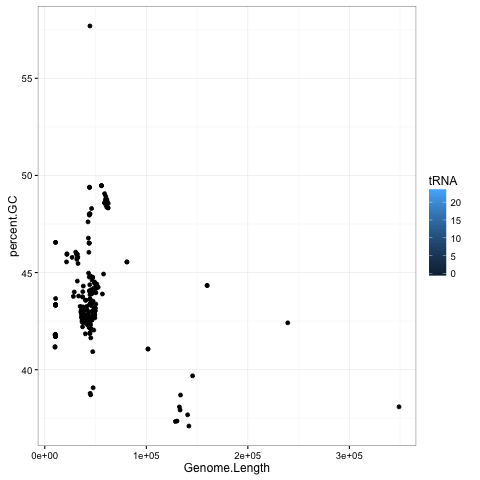

In [77]:
%%R
wacky <- t %>% ggplot(aes(Genome.Length, percent.GC, fill=tRNA)) + geom_point() + theme_bw()
plot(wacky)